# Task 4 - Word level LSTM


In [1]:
# importing all the dependencies

import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')
import nltk
import re

In [2]:
# reading the text files.

f = open("Text_1.txt","r")

if(f.mode == "r"):
    contents1 = f.read()
f.close()

f = open("Text_2.txt","r")

if(f.mode == "r"):
    contents2 = f.read()
f.close()

f = open("Text_4.txt","r")

if(f.mode == "r"):
    contents3 = f.read()
f.close()

In [3]:
# concatenating the texts
data = contents1+contents2+contents3

# changing upper case to lower case
data = data.lower()

In [4]:
# cleaning the data of special characters

data = data.replace("\n"," ")
data = data.replace("*","")
data = re.sub(r'[^a-zA-Z0-9_\s]+', '', data)

In [5]:
#Process data and calculate indexes

data = nltk.word_tokenize(data)
chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

data has 201112 characters, 13336 unique


In [6]:
# Constants and hyper-params

H_size = 100 # Size of the hidden layer
T_steps = 25 # Number of time steps (length of the sequence) used for training
learning_rate = 0.5 # Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + X_size # Size of concatenate(H, X) vector

In [7]:
# function for sigmoid activation
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# function for differentiation of sigmoid
def dsigmoid(y):
    return y * (1 - y)

# function for tanh activation
def tanh(x):
    return np.tanh(x)

# function for differentiation of tanh
def dtanh(y):
    return 1 - y * y

In [8]:
# Parameters
# We use random weights with normal distribution (0, weight_sd) for  tanh  activation function 
# and (0.5, weight_sd) for  sigmoid  activation function.
# Biases are initialized to zeros.
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad
        
class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', 
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f',
                         np.zeros((H_size, 1)))

        self.W_i = Param('W_i',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i',
                         np.zeros((H_size, 1)))

        self.W_C = Param('W_C',
                         np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C',
                         np.zeros((H_size, 1)))

        self.W_o = Param('W_o',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o',
                         np.zeros((H_size, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v',
                         np.random.randn(X_size, H_size) * weight_sd)
        self.b_v = Param('b_v',
                         np.zeros((X_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters = Parameters()

In [9]:
# function for forward pass

def forward(x, h_prev, C_prev, p = parameters):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)
    
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)

    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)

    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v)) #softmax

    return z, f, i, C_bar, C, o, h, v, y

In [10]:
# function for backward pass

def backward(target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters):
    
    assert z.shape == (X_size + H_size, 1)
    assert v.shape == (X_size, 1)
    assert y.shape == (X_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)
        
    dv = np.copy(y)
    dv[target] -= 1

    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv

    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df

    dz = (np.dot(p.W_f.v.T, df)
         + np.dot(p.W_i.v.T, di)
         + np.dot(p.W_C.v.T, dC_bar)
         + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev

In [11]:
# Clear gradients before each backward pass
def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)
        
# Clip gradients to mitigate exploding gradients
def clip_gradients(params = parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

In [12]:
# function for training through the cell
def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # Loop through time steps
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass
            
        loss += -np.log(y_s[t][targets[t], 0]) # Loss for at t
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

In [13]:
# function for generation of next character

def generate_next_char(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

In [14]:
# Update the graph and display a sample output

def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    sample_idx = generate_next_char(h_prev, C_prev, inputs[0], 20)
    txt = ' '.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
   # display.clear_output(wait=True)
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

In [15]:
# function for updating parameters after every pass
def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))
        
# To delay the keyboard interrupt to prevent the training from stopping in the middle of an iteration
import signal

class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

In [16]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / X_size) * T_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

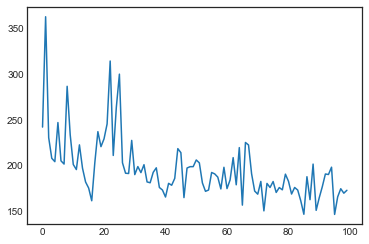

----
 but when the less to a the practices it was interior to of challenging artistic depict descent of circled know 
----
iter 100, loss 233.375810


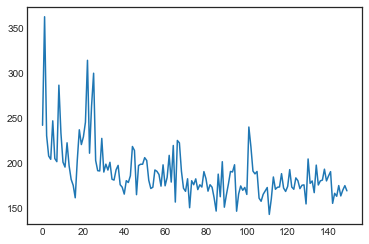

----
 of possessions nothing began it i but as m bereaved him he ado me cryptograph it truth that the balance 
----
iter 150, loss 230.643775


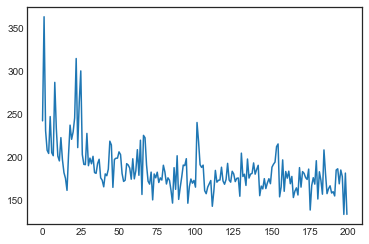

----
 keep was to it piece to we was project uncle nothing starved me my could not translation on all my 
----
iter 200, loss 227.818751


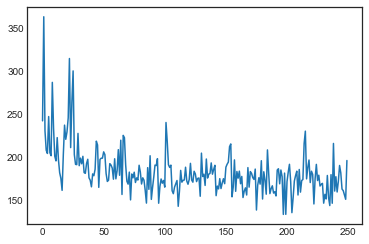

----
 never hungry the bear you with humboldt in recollect room that the first we he dinner line i delight we 
----
iter 250, loss 225.115903


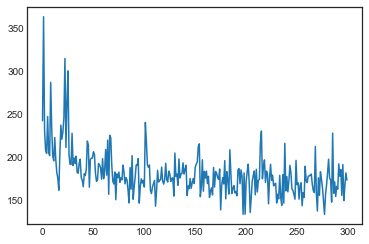

----
 england but the the phrase unique in and proof notion the engaged it nothing at sneffels which heavings is entering 
----
iter 300, loss 222.384441
SIGINT received. Delaying KeyboardInterrupt.


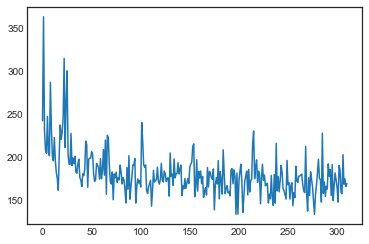

----
 uncle without remarked a the double examined a only where he it you onethat a on the excellent anything of 
----
iter 311, loss 221.880444


In [23]:
while True:
    try:
        with DelayedKeyboardInterrupt():
            # Reset
            if pointer + T_steps >= len(data) or iteration == 0:
                g_h_prev = np.zeros((H_size, 1))
                g_C_prev = np.zeros((H_size, 1))
                pointer = 0


            inputs = ([char_to_idx[ch] 
                       for ch in data[pointer: pointer + T_steps]])
            targets = ([char_to_idx[ch] 
                        for ch in data[pointer + 1: pointer + T_steps + 1]])

            loss, g_h_prev, g_C_prev = \
                forward_backward(inputs, targets, g_h_prev, g_C_prev)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001

            # Print every hundred steps
            if iteration % 50 == 0:
                update_status(inputs, g_h_prev, g_C_prev)

            update_paramters()

            plot_iter = np.append(plot_iter, [iteration])
            plot_loss = np.append(plot_loss, [loss])

            pointer += T_steps
            iteration += 1
    except KeyboardInterrupt:
        update_status(inputs, g_h_prev, g_C_prev)
        break

In [24]:
sample_idx = generate_next_char(g_h_prev, g_C_prev, inputs[0], 50)
txt = ' '.join(idx_to_char[idx] for idx in sample_idx)
print(txt)    

uncle but was had struck still oclock the its island of organization his house vision on the english is at by not viands beanlike a journey to many the yesof him he you was choler had oclock about sister was rather at oclock his the room of and yet to


Performing gradient check

In [25]:
from random import uniform

# Calculate numerical gradient
def calc_numerical_gradient(param, idx, delta, inputs, target, h_prev, C_prev):
    old_val = param.v.flat[idx]
    
    # evaluate loss at [x + delta] and [x - delta]
    param.v.flat[idx] = old_val + delta
    loss_plus_delta, _, _ = forward_backward(inputs, targets,
                                             h_prev, C_prev)
    param.v.flat[idx] = old_val - delta
    loss_mins_delta, _, _ = forward_backward(inputs, targets, 
                                             h_prev, C_prev)
    
    param.v.flat[idx] = old_val #reset

    grad_numerical = (loss_plus_delta - loss_mins_delta) / (2 * delta)
    # Clip numerical error because analytical gradient is clipped
    [grad_numerical] = np.clip([grad_numerical], -1, 1) 
    
    return grad_numerical

In [26]:
# Check gradient of each paramter matrix/vector at `num_checks` individual values
def gradient_check(num_checks, delta, inputs, target, h_prev, C_prev):
    global parameters
    
    # To calculate computed gradients
    _, _, _ =  forward_backward(inputs, targets, h_prev, C_prev)
    
    
    for param in parameters.all():
        #Make a copy because this will get modified
        d_copy = np.copy(param.d)

        # Test num_checks times
        for i in range(num_checks):
            # Pick a random index
            rnd_idx = int(uniform(0, param.v.size))
            
            grad_numerical = calc_numerical_gradient(param,
                                                     rnd_idx,
                                                     delta,
                                                     inputs,
                                                     target,
                                                     h_prev, C_prev)
            grad_analytical = d_copy.flat[rnd_idx]

            err_sum = abs(grad_numerical + grad_analytical) + 1e-09
            rel_error = abs(grad_analytical - grad_numerical) / err_sum
            
            # If relative error is greater than 1e-06
            if rel_error > 1e-06:
                print('%s (%e, %e) => %e'
                      % (param.name, grad_numerical, grad_analytical, rel_error))

In [27]:
gradient_check(10, 1e-5, inputs, targets, g_h_prev, g_C_prev)

W_v (3.552714e-09, 4.666262e-09) => 1.207888e-01
W_v (-7.852918e-06, -7.853577e-06) => 4.191132e-05
W_v (-8.449064e-06, -8.448166e-06) => 5.310158e-05
W_v (-1.278977e-06, -1.277413e-06) => 6.117059e-04
W_v (-2.647980e-05, -2.647997e-05) => 3.327500e-06
W_v (-8.597567e-07, -8.596000e-07) => 9.109709e-05
W_v (-2.934541e-07, -2.946179e-07) => 1.975534e-03
W_v (-5.158540e-07, -5.165249e-07) => 6.492148e-04
W_v (2.415845e-07, 2.428870e-07) => 2.682807e-03
W_v (2.202682e-08, 2.232935e-08) => 6.670049e-03
b_C (-2.489656e-04, -2.489608e-04) => 9.636643e-06
b_C (-2.489656e-04, -2.489608e-04) => 9.636643e-06
b_o (4.200919e-03, 4.200943e-03) => 2.823538e-06
b_o (4.200919e-03, 4.200943e-03) => 2.823538e-06
b_v (8.226451e-05, 8.226514e-05) => 3.851377e-06
b_v (7.955663e-05, 7.955625e-05) => 2.354435e-06
b_v (6.947189e-05, 6.947320e-05) => 9.391639e-06
b_v (8.122782e-05, 8.122685e-05) => 6.020982e-06
b_v (1.087059e-04, 1.087038e-04) => 9.850144e-06
b_v (1.135817e-04, 1.135827e-04) => 4.688239e-06
b_

Analysis -> I have tried this model using 50, 100 and 200 hidden units but the graphs do not show any major difference. Only the graph with 200 hidden units shows more fluctuations. Also I have tried input sequence length as 25 and 50.